Solution by Eliott Rosenberg (enr27@cornell.edu)

In [2]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

First, we use the provided code to create the qmolecule object for LiH.

In [3]:
import numpy as np
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

Next, we need to generate a qubit Hamiltonian corresponding to this problem. We want to simplify this Hamiltonian as much as possible. That is, we want to minimize the number of qubits needed to represent the Hamiltonian since this will mean that we need fewer CNOT gates to entangle the qubits.

To do this, we will use the ParityMapper with `two_qubit_reduction=True`. We will also freeze the core (non-valence) electrons and remove unoccupied orbitals. We further identify the $Z_2$ symmetries and keep only the sector that contains the ground state.

Relevant documentation pages:

https://qiskit.org/documentation/nature/stubs/qiskit_nature.converters.second_quantization.QubitConverter.html

https://qiskit.org/documentation/nature/stubs/qiskit_nature.transformers.FreezeCoreTransformer.html

In [5]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter


# unoccupied orbitals that will be removed.
#This is following https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Running-VQE-on-a-Statevector-Simulator,
#in which these two orbitals are removed.
# You can confirm that removing these orbitals only has a small effect on the ground state energy by
# setting remove_list to [] and seeing how this affects the exact ground state energy.
remove_list = [3,4]
# freeze_core = True means that we are not treating the core electron as part of our quantum system
transformer = [FreezeCoreTransformer(freeze_core=True,remove_orbitals=remove_list)]
problem = ElectronicStructureProblem(driver,q_molecule_transformers=transformer)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()
# Hamiltonian
main_op = second_q_ops[0]

mapper = ParityMapper()

# The Hamiltonian has additional Z2 symmetries. We can reduce the problem size by working in a particular
# eigenspace of these symmetry operators. We just have to make sure that the eigenspace we pick
# contains the ground state. You can confirm that it contains the ground state by getting rid of
# z2symmetry_reduction=[1,1] and seeing that this doesn't affect the ground state energy.
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1])
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)


We can see what the qubit Hamiltonian looks like now. With all of these simplifications, we have reduced it to just 4 qubits.

In [8]:
print(qubit_op)

-0.20316606150558716 * IIII
+ (-0.3652586902160363+1.3877787807814457e-17j) * ZIII
+ 0.09275994933497261 * IZII
- 0.21188984297009283 * ZZII
+ 0.36525869021603635 * IIZI
- 0.11384335176465243 * ZIZI
+ 0.11395251883047357 * IZZI
+ (-0.060440128573150384+3.469446951953614e-18j) * ZZZI
+ (-0.09275994933497239-3.469446951953614e-18j) * IIIZ
+ 0.11395251883047357 * ZIIZ
+ (-0.12274244052545254-6.938893903907228e-18j) * IZIZ
+ 0.05628878167216692 * ZZIZ
+ (-0.2118898429700929+1.3877787807814457e-17j) * IIZZ
+ 0.060440128573150384 * ZIZZ
+ (-0.05628878167216692-3.469446951953614e-18j) * IZZZ
+ 0.08460131391824227 * ZZZZ
+ 0.01938940858370424 * XIII
- 0.01938940858370424 * XZII
+ (-0.010952773573795035+8.673617379884035e-19j) * XIZI
+ 0.010952773573795035 * XZZI
+ 0.012779333033012864 * XIIZ
- 0.012779333033012864 * XZIZ
- 0.00900250124383856 * XIZZ
+ 0.00900250124383856 * XZZZ
+ 0.0029411410872898737 * IXII
+ 0.0029411410872898737 * ZXII
- 0.010681856282928344 * IXZI
- 0.010681856282928344 * 

We can also compute the exact ground state energy so that we know what we're targeting and to confirm that our various simplifications haven't changed the ground state energy too much.

In [9]:
# exact ground state energy:

from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347423
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


We see that, with the frozen core and the removed orbitals, the ground state energy is -1.08870601573474. For comparison, if we had not removed the orbitals, the ground state energy would have been -1.08978239634873, so removing the orbitals leads to an error of 0.001, within the chemical accuracy. Adding on the extracted energy from the core, these give -8.907396311 and -8.908472692, respectively, whereas the exact ground state energy, treating the core quantum mechanically, is -8.90869711642421. We see that freezing the core is a very good approximation, causing only a 0.0002 discrepancy, an order of magnitude smaller than the chemical accuracy.

Next, we are instructed to begin in the Hartee-Fock initial state:

In [10]:
# initial state:

from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


Next, we construct an ansatz. It uses 3 CNOTs to entangle the 4 qubits and has lots of tunable parameters. The UGate is a general 1-qubit unitary. If you change optimize_externally to True, then we import the optimial parameters, which I found using an analytic gradient optimizer that I wrote independently of this challenge. (In this case, we tack on an Rz gate so that there is one parameter for the qiskit optimizer to optimize.)

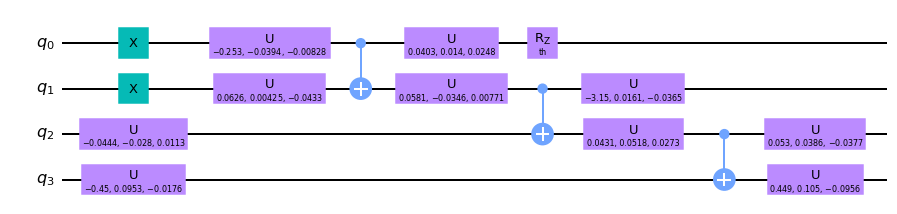

In [20]:
num_qubits = init_state.num_qubits
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.circuit.library import TwoLocal
ansatz = QuantumCircuit(num_qubits)

optimize_externally = True

if optimize_externally:
    theta = np.genfromtxt('theta1.csv')
    whichParameter = 0
    for q in range(num_qubits):
        ansatz.u(theta[whichParameter],theta[whichParameter+1],theta[whichParameter+2],q)
        whichParameter += 3
    for q in range(num_qubits-1):
        ansatz.cx(q,q+1)
        ansatz.u(theta[whichParameter],theta[whichParameter+1],theta[whichParameter+2],q)
        whichParameter += 3
        ansatz.u(theta[whichParameter],theta[whichParameter+1],theta[whichParameter+2],q+1)
        whichParameter += 3
    ansatz.rz(Parameter('th'),0)
else:
    whichParameter = 0
    for q in range(num_qubits):
        ansatz.u(Parameter('th'+str(whichParameter)),Parameter('th'+str(whichParameter+1)),Parameter('th'+str(whichParameter+2)),q)
        whichParameter += 3
    for q in range(num_qubits-1):
        ansatz.cx(q,q+1)
        ansatz.u(Parameter('th'+str(whichParameter)),Parameter('th'+str(whichParameter+1)),Parameter('th'+str(whichParameter+2)),q)
        whichParameter += 3
        ansatz.u(Parameter('th'+str(whichParameter)),Parameter('th'+str(whichParameter+1)),Parameter('th'+str(whichParameter+2)),q+1)
        whichParameter += 3

ansatz.compose(init_state, front=True, inplace=True)

ansatz.draw()

Finally, we optimize the ansatz:

In [21]:
# backend
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

# optimizer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer = COBYLA(maxiter=5000)

# optimize
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
# use my initial point instead:
#initial_point = theta

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 22,
    'eigenstate': array([-3.89758931e-03+5.05284346e-04j, -4.99760564e-03+2.42634388e-04j,
        2.76009508e-02-1.14635881e-03j, -9.90754881e-01+3.16508758e-02j,
       -5.45821668e-02+1.68930357e-03j, -2.84478848e-04+2.90127440e-05j,
        1.01478854e-03-6.31043250e-06j, -2.65637141e-02-1.73476657e-04j,
       -3.00041642e-03+2.11539917e-04j, -5.95000930e-06+1.66044688e-06j,
        2.49699861e-06+1.63925480e-07j,  4.53865114e-04-3.11140840e-05j,
        1.13522395e-01-3.62190200e-03j,  3.16477449e-04-5.80491429e-05j,
       -5.89252039e-04+9.29102833e-06j,  6.19318516e-04-2.16589103e-06j]),
    'eigenvalue': -1.0863813746213205,
    'optimal_parameters': {Parameter(th): -5.3906249999999796e-05},
    'optimal_point': array([-5.390625e-05]),
    'optimal_value': -1.0863813746213205,
    'optimizer_evals': 22,
    'optimizer_time': 0.16680502891540527}


We see that this converges to within chemical accuracy, so we're done and can submit.

In [18]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

